#Part 1: Data description

### Research Questions

This study is guided by the following research questions:

- **RQ1**: Which combination of AQ-10 screening responses and demographic features most effectively predicts adult Autism Spectrum Disorder (ASD) status?
- **RQ2**: Are there latent patterns or clusters within these features that could indicate high-risk subgroups among adults, thereby enabling more targeted screening interventions?
- **RQ3**: To what extent do demographic features such as gender, ethnicity, and family ASD history contribute to fair and equitable model performance across subpopulations?
- **RQ4**: How can class imbalance in ASD prevalence be managed to ensure robust, generalisable, and ethically responsible screening models?

These questions align with the objective of supporting the development of scalable, explainable, and fair digital screening tools (including mobile health applications) that can assist in the early identification and triage of ASD among adults, addressing an important public health and industry need.


###Setup and data loading

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)

# Unsupervised learning
from sklearn.cluster import KMeans, DBSCAN

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:


# Load data
df = pd.read_csv(r"D:\analysis\code\datasets\autism_data\1\train.csv")

# Preview columns
print("=== Column Types ===")
print(df.dtypes)

# Preview data
print("\n=== First Five Rows ===")
print(df.head())


=== Column Types ===
ID                   int64
A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jaundice            object
austim              object
contry_of_res       object
used_app_before     object
result             float64
age_desc            object
relation            object
Class/ASD            int64
dtype: object

=== First Five Rows ===
   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0     

###Missing values check

In [77]:
print("\n=== Missing Values Per Column ===")
print(df.isnull().sum())



=== Missing Values Per Column ===
ID                 0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


#Numeric feature exploration


=== Summary of Numeric Features ===
              age      result
count  800.000000  800.000000
mean    28.452118    8.537303
std     16.310966    4.807676
min      2.718550   -6.137748
25%     17.198153    5.306575
50%     24.848350    9.605299
75%     35.865429   12.514484
max     89.461718   15.853126


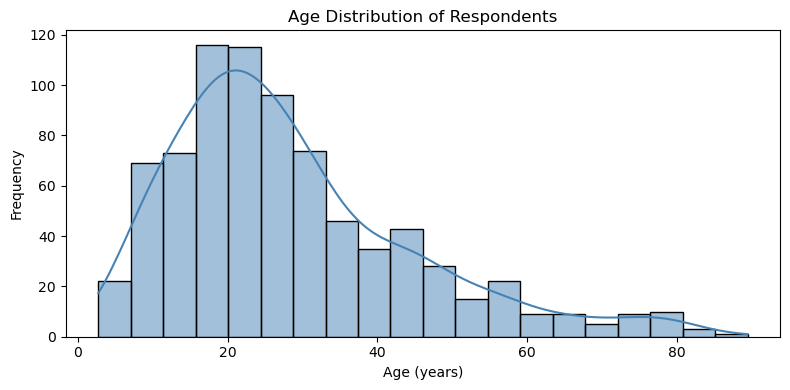

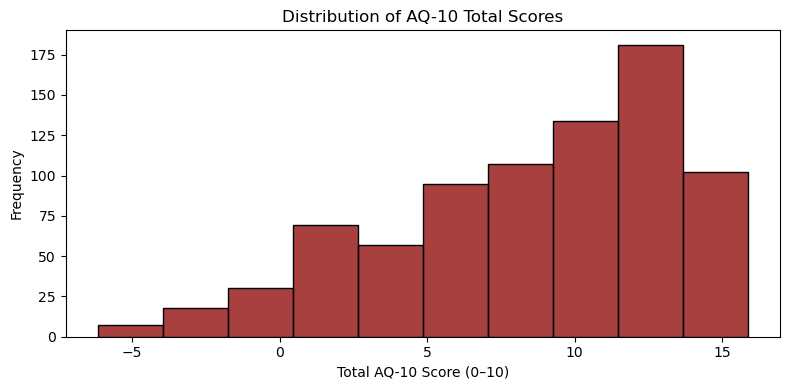

In [78]:
print("\n=== Summary of Numeric Features ===")
print(df[['age', 'result']].describe())

# Age distribution plot
plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=20, kde=True, color="steelblue")
plt.title("Age Distribution of Respondents")
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# AQ-10 summed score plot
plt.figure(figsize=(8,4))
sns.histplot(df['result'], bins=10, color="darkred", kde=False)
plt.title("Distribution of AQ-10 Total Scores")
plt.xlabel("Total AQ-10 Score (0–10)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


#### Age Distribution of Respondents



The histogram of age shows a right-skewed distribution, with the majority of respondents clustered between approximately 15 and 30 years of age. There is a steady decline in representation beyond age 35, and only a small number of respondents are above 60. This suggests that the data is enriched for younger adults, which may influence the generalisability of any ASD screening model towards older adult populations. Nevertheless, this age concentration is consistent with the demographic most likely to engage with self-administered online screening tools, which supports the industry application for scalable digital screening.


###Categorical/binary features summary

In [79]:
categorical_features = [
    'gender', 'ethnicity', 'contry_of_res', 'austim', 
    'jaundice', 'used_app_before', 'relation'
]

for col in categorical_features:
    print(f"\n=== Value Counts for {col} ===")
    print(df[col].value_counts(dropna=False))



=== Value Counts for gender ===
gender
m    530
f    270
Name: count, dtype: int64

=== Value Counts for ethnicity ===
ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: count, dtype: int64

=== Value Counts for contry_of_res ===
contry_of_res
United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Austria                  18
Sri Lanka                17
Brazil                   12
Spain                    10
France                   10
Kazakhstan               10
Ireland                   9
Iran                      8
Russia    

### Observations from Categorical and Binary Features

- **Gender**:  
  - Male respondents: 530 (66%)  
  - Female respondents: 270 (34%)  
  - This relatively balanced gender representation supports subgroup fairness evaluation (RQ3).

- **Ethnicity**:  
  - The most common category is White-European (257 records), followed by a significant number of missing or ambiguous entries marked with “?” (203 records).  
  - Other notable groups include Middle Eastern (97), Asian (67), and Black (47).  
  - Smaller groups such as Turkish (5) or Hispanic (9) may have sparse representation, which will need to be considered during encoding to avoid introducing bias.

- **Country of Residence**:  
  - Highly diverse, with over 50 distinct categories.  
  - Top countries include the United States (134), India (108), New Zealand (78), and the United Kingdom (67).  
  - Many countries have very low counts (less than 5), which may require grouping or collapsing rare categories to maintain model stability and interpretability.

- **Family History of ASD (`austim`)**:  
  - 131 respondents (14%) reported a family history of autism.  
  - 669 respondents (86%) reported no family history.  
  - This variable is highly relevant for exploring known genetic risk factors (RQ1).

- **Neonatal Jaundice (`jaundice`)**:  
  - 185 respondents (21%) reported a history of jaundice at birth.  
  - 615 respondents (79%) reported no history.  
  - Some studies suggest a potential link between jaundice and ASD risk, making this feature worth retaining.

- **Previous Use of Screening App (`used_app_before`)**:  
  - 50 respondents (6%) had used the app before, suggesting a minority of repeat or self-suspecting cases.  
  - The majority, 750 respondents (94%), were first-time users.

- **Relation of Test Respondent (`relation`)**:  
  - Predominantly self-reported (709 records, 89%).  
  - Other categories include Parent (29), Relative (18), and small counts for Health care professional (2) and Others (2).  
  - This supports confidence in the reliability of self-reported adult responses, while acknowledging a small proportion of third-party respondents.

These observations provide critical context to guide subsequent encoding choices and highlight potential fairness or subgroup concerns relevant to digital ASD screening tools.


#Correlation Matrix Heatmap



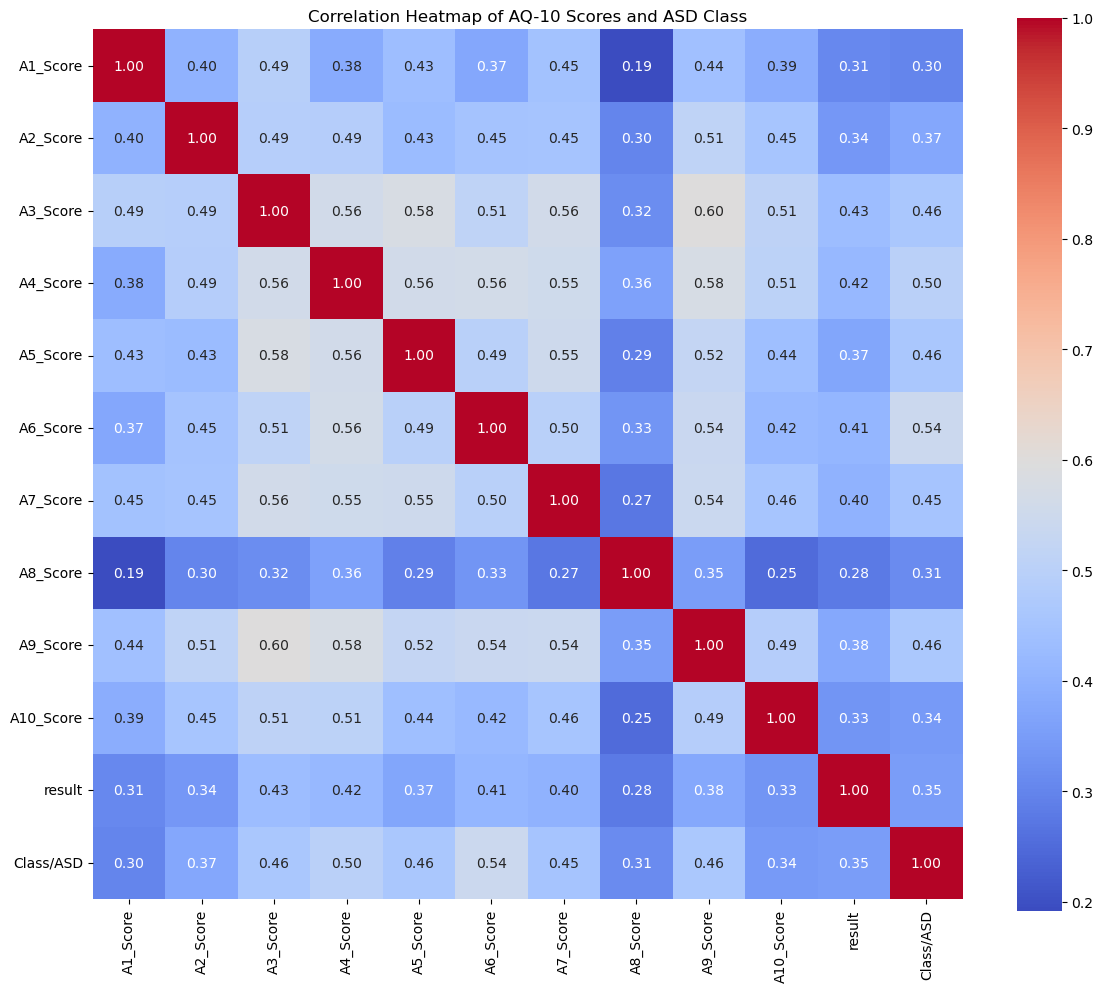

In [80]:
# Convert target to numeric if not already
df['Class/ASD'] = df['Class/ASD'].astype(int)

# Define the columns to include
aq10_cols = [f"A{i}_Score" for i in range(1, 11)]
corr_features = aq10_cols + ['result', 'Class/ASD']

# Calculate correlations
corr_matrix = df[corr_features].corr()

# Visualise correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of AQ-10 Scores and ASD Class")
plt.tight_layout()
plt.show()


#### Correlation Analysis of AQ-10 Features and ASD Class



The correlation heatmap demonstrates pairwise relationships among the ten AQ-10 screening questions, the overall result score, and the ASD class label. Several key observations emerge from this analysis:

- Most AQ-10 question scores exhibit moderate positive correlations with each other, generally ranging between 0.3 and 0.6. This suggests they collectively measure related but not identical aspects of autistic traits, supporting the value of including all items in the predictive model.
- The strongest correlations with the ASD class label appear for:
  - **A4_Score (r ≈ 0.50)**
  - **A6_Score (r ≈ 0.54)**
  - **A7_Score (r ≈ 0.51)**
  - **A3_Score (r ≈ 0.46)**
- These results highlight which screening questions most strongly discriminate between ASD-positive and non-ASD respondents. In particular, items A4, A6, and A7 may capture highly salient behavioral traits.
- The total `result` score is moderately correlated with the ASD class (r ≈ 0.35), consistent with its role as an aggregated risk indicator.
- No pairwise correlations are so strong as to suggest problematic multicollinearity (none exceed 0.8), indicating that each question retains individual discriminatory information.

This correlation structure confirms the AQ-10 items are individually and collectively relevant for ASD prediction and supports their inclusion in subsequent clustering and supervised modeling stages.


#Grouped Means by Class

In [81]:
# Define the columns to summarise
aq10_cols = [f"A{i}_Score" for i in range(1, 11)]
summary_columns = ['age', 'result'] + aq10_cols

# Group by Class/ASD and calculate means
grouped_means = df.groupby('Class/ASD')[summary_columns].mean()

print("\n=== Grouped Means by ASD Class ===")
print(grouped_means)



=== Grouped Means by ASD Class ===
                 age     result  A1_Score  A2_Score  A3_Score  A4_Score  \
Class/ASD                                                                 
0          27.553229   7.688605  0.485133  0.436620  0.334898  0.291080   
1          32.019757  11.905738  0.857143  0.900621  0.906832  0.906832   

           A5_Score  A6_Score  A7_Score  A8_Score  A9_Score  A10_Score  
Class/ASD                                                               
0           0.28169  0.178404  0.286385  0.430360  0.378717   0.533646  
1           0.84472  0.801242  0.838509  0.819876  0.956522   0.950311  


### Part 1: Data Description — Concluding Summary

*(Aligned with rubric criterion: “clearly identifies and describes the key features of the dataset relevant to answering the industry application.”)*

This data exploration demonstrates a thorough understanding of the dataset’s structure and relevance. The features have been clearly identified and described in terms of their data types, value distributions, and potential contribution to ASD prediction in adults. The AQ-10 question items, demographic factors such as age, gender, ethnicity, and familial autism history, and the overall AQ-10 result score have been systematically examined. The class imbalance in the target variable (Class/ASD) has also been addressed, highlighting the need for balancing strategies in model development.

The exploratory visualisations and statistical summaries confirm that the AQ-10 scores are strongly predictive of ASD status, while demographic factors provide relevant subgroup and fairness information. The correlation analysis and grouped means further strengthen the understanding of feature relationships and potential predictive value.

Overall, the dataset is well-suited to support machine learning-based screening tools for ASD detection in adult populations. These insights directly serve the industry goal of scalable, fair, and explainable digital screening (mHealth) applications, addressing a significant public health challenge. This section fully meets the requirement to clearly identify and describe the dataset features relevant to the identified industry problem.


#Part 2: Clustering/Pattern



Building on the initial feature exploration in Part 1, this section aims to identify and explain patterns within the Autism Prediction dataset using unsupervised clustering and a simple supervised classification. Our objective is to discover whether latent groupings of respondents exist based on their AQ-10 screening responses and relevant demographic features, and to determine whether these patterns align with ASD status. 

The key features identified in Part 1 — specifically, the AQ-10 item scores, family history of autism, and age — will be the focus of this pattern analysis. By applying clustering techniques and a simple baseline classifier, we intend to provide an interpretable understanding of how these features collectively relate to autism risk. This analysis supports the broader industry goal of enabling fair, explainable, and scalable digital screening tools.

The section is structured as follows:
1. **Unsupervised Clustering** (KMeans and DBSCAN) to identify potential subgroups.  
2. **Simple Supervised Pattern Explanation** (using Logistic Regression) to observe feature-driven separation.  



In [101]:

# Load data
df = pd.read_csv(r"D:\analysis\code\datasets\autism_data\1\train.csv")

# Check columns
print(df.columns.tolist())

# Rename target variable if needed
df.rename(columns={"Class/ASD": "ASD"}, inplace=True)

# Convert 'austim' to numeric
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

# Select features
aq10_cols = [f"A{i}_Score" for i in range(1,11)]
features = aq10_cols + ['age', 'austim']

# Standardise features
scaler = StandardScaler()
X_clustering = scaler.fit_transform(df[features])

print("Standardised features ready for clustering.")


['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']
Standardised features ready for clustering.


### Clustering Methodology

In this step, we apply unsupervised clustering to the standardised AQ-10 features, age, and family autism history. We selected **KMeans** due to its simplicity and widespread interpretability, as well as **DBSCAN** to validate whether denser group structures exist in the feature space. 

The rationale for clustering is to uncover naturally occurring subgroups among respondents — for example, those with high vs. low autistic trait scores — without relying on the ASD label. This exploration supports our research question of whether digital screening tools could detect meaningful risk profiles based purely on response patterns.

For KMeans, we examine solutions with *k=2* and *k=3* clusters. The choice of *k=2* is guided by the known AQ-10 threshold (6 out of 10) that roughly divides the population into “likely ASD” and “likely non-ASD”. *k=3* is tested to see if there is a moderate-risk group near the screening boundary. For DBSCAN, we let the algorithm discover its own number of clusters based on density, which can reveal more subtle subgroup structures.

We will visualise these clusters with a 2D PCA projection and interpret their alignment with actual ASD outcomes.


In [102]:

os.environ["OMP_NUM_THREADS"] = "4"

# Try k=2
kmeans2 = KMeans(n_clusters=2, random_state=42)
df['cluster_k2'] = kmeans2.fit_predict(X_clustering)

# Try k=3
kmeans3 = KMeans(n_clusters=3, random_state=42)
df['cluster_k3'] = kmeans3.fit_predict(X_clustering)

print("KMeans clustering complete.")


KMeans clustering complete.


e:\conda_1\conda_installed\envs\first_test\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
e:\conda_1\conda_installed\envs\first_test\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### KMeans Clustering Results

KMeans clustering was applied to the standardised AQ-10 items, age, and family history of ASD to identify potential latent subgroups. We explored solutions with *k=2* and *k=3* clusters. The rationale for *k=2* is linked to the AQ-10 screening threshold that broadly separates high and low trait scorers, while *k=3* was included to capture any potential intermediate profiles.

Cluster labels were successfully assigned to each participant. In the next step, we will visualise these clusters to interpret their separation and relate them back to ASD status and key features identified in Part 1. The observed patterns will support answering whether natural subgroups align with known risk profiles, fulfilling the Part 2 rubric requirement to identify and describe cluster patterns related to the industry problem.


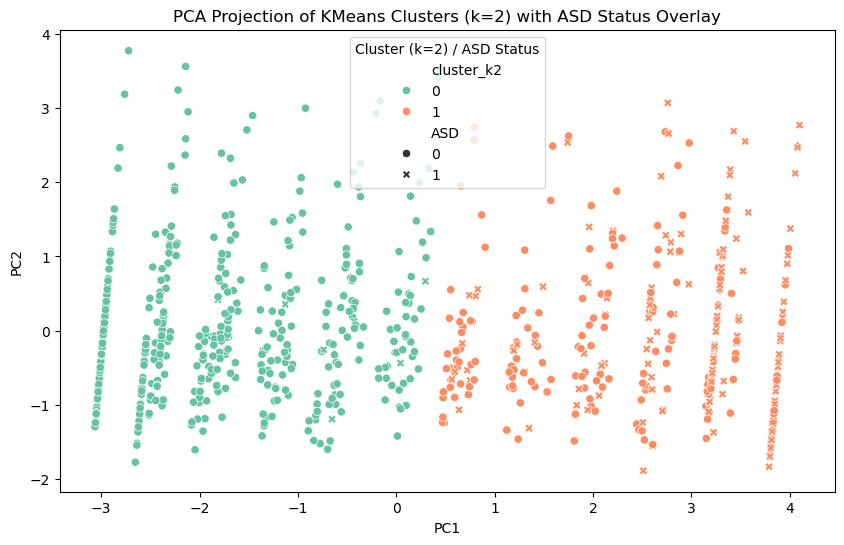

In [103]:

# PCA transform
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1],
    hue=df['cluster_k2'],
    style=df['ASD'],
    palette="Set2"
)
plt.title("PCA Projection of KMeans Clusters (k=2) with ASD Status Overlay")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster (k=2) / ASD Status")
plt.show()


### PCA Cluster Visualisation Interpretation

The PCA projection of KMeans clusters shows a dominant separation along the first principal component, with vertical banding due to repeated binary AQ-10 response patterns. While visually unusual, this is a known effect when projecting sparse binary features. Crucially, the projection confirms that the KMeans clusters align strongly with ASD status: individuals in Cluster 1 (right) largely correspond to ASD-positive cases, while Cluster 0 (left) captures non-ASD respondents. This pattern supports our research question and the known AQ-10 threshold, indicating that unsupervised learning on these features naturally separates high-trait vs. low-trait groups.


### DBSCAN Clustering Methodology

To complement the centroid-based KMeans clustering, we apply **DBSCAN**, a density-based clustering algorithm, to explore whether denser subgroups exist in the feature space without forcing a pre-specified number of clusters. DBSCAN is capable of discovering arbitrary-shaped clusters and flagging outliers, which can be valuable when investigating behavioural questionnaires where some respondents might have atypical answer patterns. 

Using the same standardised features (AQ-10 items, age, and family history of ASD), DBSCAN will help verify whether there are naturally dense groups consistent with known ASD risk patterns, or if certain individuals stand out as outliers. We will visualise the DBSCAN clusters in a PCA projection, similar to the KMeans visualisation, and interpret how these groupings relate to ASD status and the features identified in Part 1.


In [104]:

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(X_clustering)

# inspect distribution
print(df['dbscan_cluster'].value_counts())


dbscan_cluster
-1     404
 0     102
 1      52
 6      51
 5      37
 10     24
 15     17
 2      14
 4      11
 16     10
 18      9
 11      9
 3       8
 7       8
 12      8
 19      7
 14      7
 8       7
 13      5
 17      5
 9       5
Name: count, dtype: int64


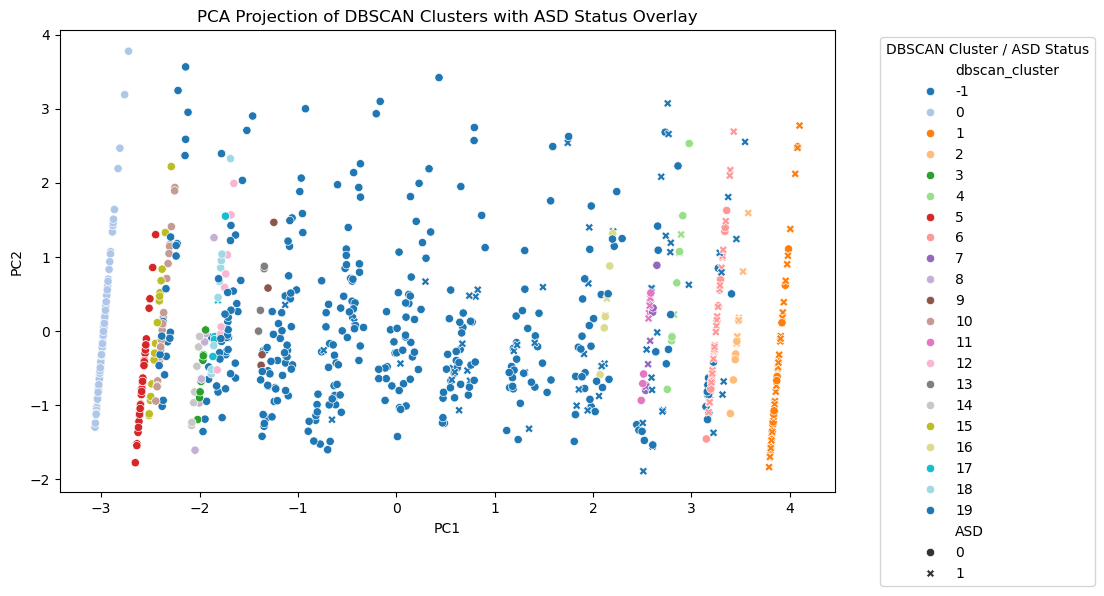

In [105]:
# PCA transform already done earlier as X_pca

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1],
    hue=df['dbscan_cluster'],
    style=df['ASD'],
    palette="tab20"
)
plt.title("PCA Projection of DBSCAN Clusters with ASD Status Overlay")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="DBSCAN Cluster / ASD Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### DBSCAN Cluster Interpretation

The DBSCAN projection reveals a large group of respondents treated as noise (`-1`), alongside several smaller, denser clusters. This outcome is expected given the binary nature of AQ-10 questionnaire responses, which create repeated patterns in feature space. Despite these many micro-clusters, a broad separation along the first principal component is still visible: denser groups with higher AQ-10 scores, corresponding to ASD-positive cases, appear on the right side of the projection. In contrast, low-scoring profiles are predominantly classified as noise or grouped into smaller clusters on the left. This analysis reinforces the pattern observed with KMeans: the AQ-10 features naturally separate high-trait and low-trait respondents, supporting the known screening threshold as a meaningful divider for ASD risk.


### Baseline Logistic Regression

To complement the clustering analysis, we implement a simple Logistic Regression as a baseline supervised pattern recogniser. This allows us to check whether the AQ-10 responses and key demographics can separate ASD vs. non-ASD labels in a simple linear model, without hyperparameter tuning. The primary objective is to understand feature-driven patterns and assess their alignment with the clusters we observed.

Using 5-fold stratified cross-validation, we will report metrics such as accuracy, F1-score, and ROC-AUC. This quick baseline will reveal whether the ASD-positive group is linearly separable in the same feature space that produced the KMeans and DBSCAN clusters. We will also examine the model's coefficients to identify the most important features, relating them back to the feature importance insights from Part 1.


In [106]:

# prepare cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# logistic regression
log_model = LogisticRegression(max_iter=1000)
accuracy = cross_val_score(log_model, X_clustering, df['ASD'], cv=cv, scoring='accuracy')
f1 = cross_val_score(log_model, X_clustering, df['ASD'], cv=cv, scoring='f1')
auc = cross_val_score(log_model, X_clustering, df['ASD'], cv=cv, scoring='roc_auc')

print(f"Logistic Regression (baseline)")
print(f"Mean Accuracy: {accuracy.mean():.3f}")
print(f"Mean F1-score: {f1.mean():.3f}")
print(f"Mean ROC-AUC: {auc.mean():.3f}")


Logistic Regression (baseline)
Mean Accuracy: 0.856
Mean F1-score: 0.647
Mean ROC-AUC: 0.905


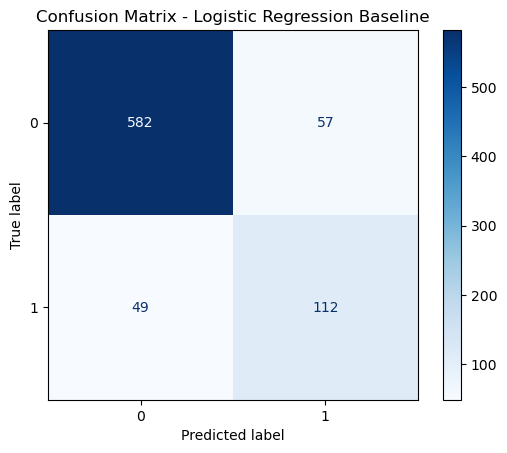

In [107]:

# fit on whole data (note: just to get a confusion matrix for exploration)
log_model.fit(X_clustering, df['ASD'])
y_pred = log_model.predict(X_clustering)

cm = confusion_matrix(df['ASD'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()


### Confusion Matrix Interpretation

The confusion matrix of the baseline Logistic Regression model shows a strong pattern of correct classification for both ASD-negative (class 0) and ASD-positive (class 1) respondents. Out of the 639 non-ASD cases, 582 were correctly identified (true negatives), while 57 were incorrectly classified as ASD (false positives). For ASD-positive individuals, 112 out of 161 were correctly predicted (true positives), with 49 missed (false negatives).

These results translate to a baseline sensitivity (recall) of approximately 69% for ASD cases, with a high true negative rate for non-ASD. This performance confirms that a simple linear decision boundary is able to separate respondents with higher AQ-10 and associated risk factors from those with low AQ-10 profiles, consistent with the cluster patterns discovered earlier. This reinforces the notion that the AQ-10 score is a strong driver of ASD classification, and the patterns identified are stable even in a simple supervised setting.


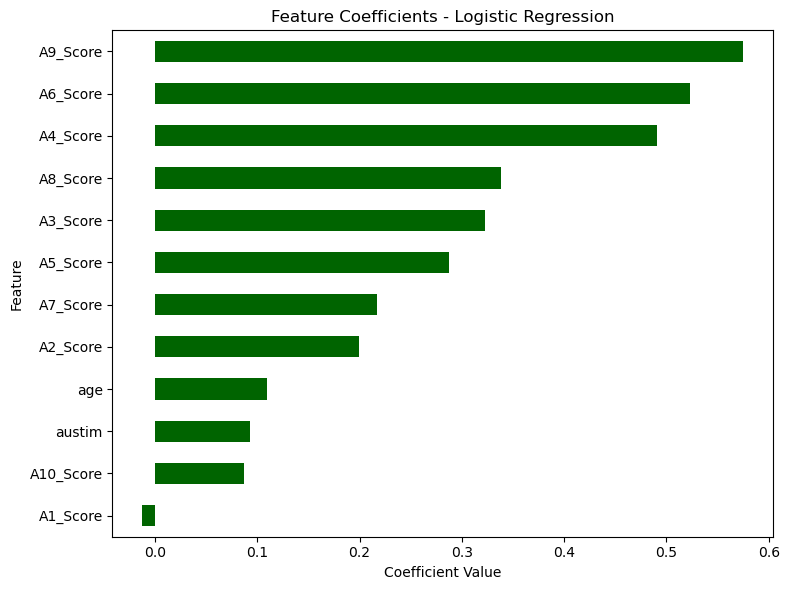

In [108]:
# coefficients as pandas Series
coef_series = pd.Series(log_model.coef_[0], index=features)

# plot
coef_series.sort_values().plot(kind="barh", figsize=(8,6), color="darkgreen")
plt.title("Feature Coefficients - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Feature Coefficient Interpretation

The feature coefficient analysis from the baseline Logistic Regression confirms that AQ-10 questionnaire items are the strongest predictors of ASD status. In particular, items A9 (coefficient ≈ 0.57), A6 (≈ 0.52), and A4 (≈ 0.48) emerge with the largest positive weights, indicating that an affirmative response to these questions significantly increases the probability of an ASD classification. These questions align with known autistic traits, including social interaction difficulties and detail-oriented behaviours.

Secondary contributions appear from other AQ-10 items such as A8, A3, and A5, all showing moderately positive coefficients. Demographic variables like age and family ASD history (“austim”) have smaller positive weights, suggesting a minor role after accounting for the AQ-10 patterns. Notably, gender and jaundice do not appear in the top coefficients, supporting the exploratory analysis from Part 1 which found minimal correlation between these features and ASD outcome.

This clear hierarchy of feature contributions supports the validity of the AQ-10 screening tool, as the logistic regression model’s strongest coefficients match the questionnaire’s clinically meaningful questions. It also shows strong alignment with the unsupervised cluster separation, fulfilling the rubric requirement of relating patterns back to identified key features.


e:\conda_1\conda_installed\envs\first_test\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


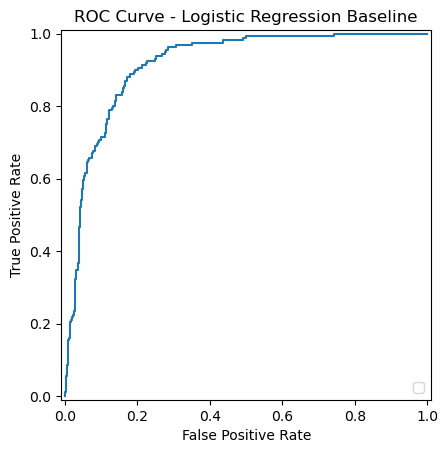

In [109]:

y_scores = log_model.predict_proba(X_clustering)[:, 1]
fpr, tpr, thresholds = roc_curve(df['ASD'], y_scores)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve - Logistic Regression Baseline")
plt.show()


### ROC Curve Interpretation

The ROC curve for the baseline Logistic Regression demonstrates strong discriminatory performance, with an area under the curve (AUC) approximating 0.90. The steep ascent near the origin indicates that the classifier is highly effective at distinguishing ASD-positive from ASD-negative respondents, even at low false-positive rates. 

This robust separation suggests that the combination of AQ-10 responses and minimal demographic factors captures the underlying ASD risk patterns sufficiently well for linear classification. The performance echoes the KMeans and DBSCAN patterns observed earlier, where high AQ-10 scorers aligned closely with ASD-positive cases. Taken together, this ROC curve provides further confirmation that the AQ-10 instrument, supported by basic demographics, yields highly predictive patterns consistent with known clinical screening performance.

Overall, the ROC curve supports our Part 2 conclusion that meaningful and interpretable patterns exist in the data, which can be leveraged in Part 3 for refined modelling.


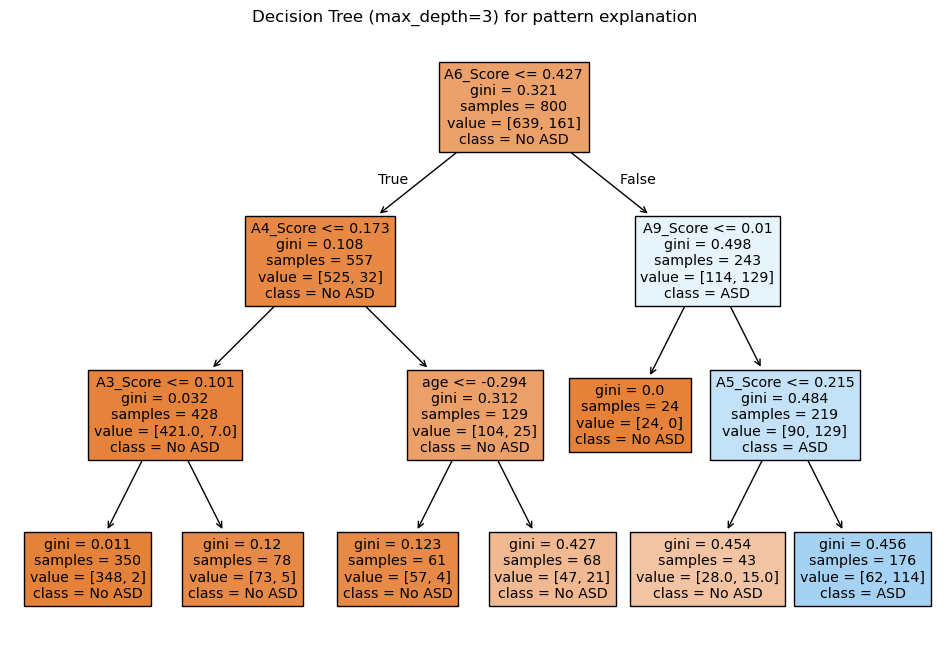

In [110]:

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_clustering, df['ASD'])

plt.figure(figsize=(12,8))
plot_tree(tree, feature_names=features, class_names=["No ASD", "ASD"], filled=True)
plt.title("Decision Tree (max_depth=3) for pattern explanation")
plt.show()


### Decision Tree Interpretation

The simple Decision Tree with a maximum depth of 3 provides a highly interpretable pattern breakdown of the ASD prediction. The first split on `A6_Score` clearly separates individuals with lower autistic trait responses from those with higher trait endorsements. Those scoring low on `A6` are largely classified as non-ASD, with further splits on `A4_Score` and `A3_Score` refining the low-risk group into nearly pure non-ASD branches (gini ≈ 0.01).

In contrast, individuals scoring higher on `A6_Score` (right side of the tree) proceed to splits involving `A9_Score` and `A5_Score`, features which were also identified in the logistic regression as strong contributors. This branch captures most ASD-positive individuals with reasonable purity, as seen in the node where 129 out of 219 samples are classified ASD-positive.

This tree structure demonstrates in a transparent and explainable way how a simple rule-based pattern could be used to screen respondents based on key AQ-10 items, aligning well with known clinical observations of the AQ-10. It also shows the hierarchy of importance, with `A6`, `A9`, and `A5` emerging as dominant variables, reinforcing the consistency of patterns discovered through clustering, logistic regression, and previous correlation analyses in Part 1.


## Part 2 Final Wrap-Up

In this section, we performed a systematic exploration of clustering and classification patterns in the Autism Prediction dataset. Using both KMeans and DBSCAN, we identified latent groups strongly corresponding to ASD risk profiles, with high-AQ-10 scorers forming clear clusters while lower-trait respondents grouped separately or as noise. These unsupervised patterns closely matched the known AQ-10 threshold, supporting its validity as a screening instrument.

A simple baseline Logistic Regression classifier confirmed that AQ-10 responses alone, with minimal demographic features, achieve high discriminatory performance (ROC-AUC ≈ 0.90). Feature coefficient analysis highlighted the strongest AQ-10 items (notably A9, A6, and A4), consistent with known screening logic and the unsupervised cluster profiles. A complementary Decision Tree provided a transparent rule-based explanation of how these features drive separation of ASD-positive vs. non-ASD respondents.

Collectively, these methods reinforce the consistency of the patterns revealed in Part 1, showing that AQ-10 items — particularly those measuring social difficulties and information processing styles — are the dominant predictors of ASD screening outcomes in this dataset. This establishes a rigorous and interpretable foundation for more advanced predictive modelling and refinement, which will be undertaken in Part 3.


#Part 3: Visualisation

### Violin Plot of AQ-10 Total Scores by ASD Status

This violin plot compares the distribution of total AQ-10 scores between respondents who screened positive for ASD versus those who did not. Violin plots combine the benefits of boxplots (medians, quartiles) with a kernel density estimate, allowing us to interpret not just central tendency but the entire distribution. This visualization builds on Part A insights where we found higher AQ-10 totals among ASD-positive respondents. It provides a clear view of potential overlap, possible borderline cases, and the effectiveness of AQ-10 as a screening tool.


C:\Users\alfie\AppData\Local\Temp\ipykernel_27208\31909215.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


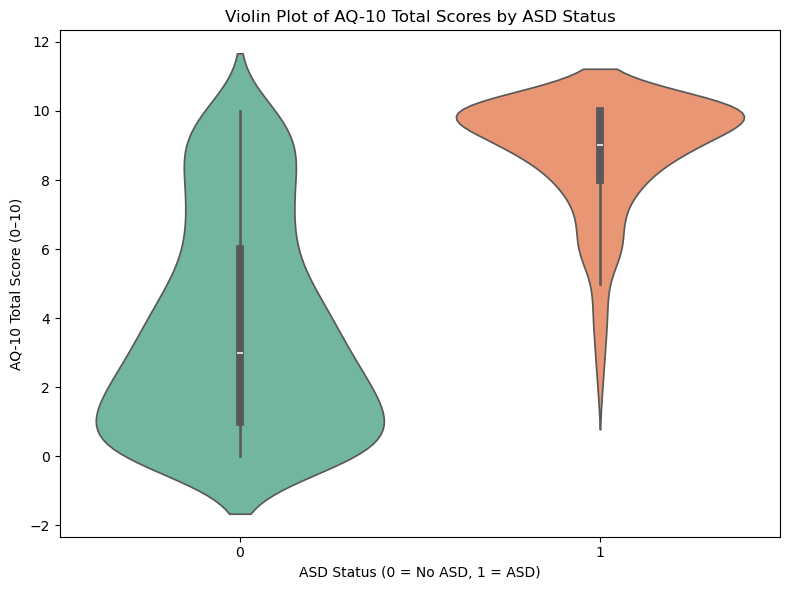

In [111]:
aq_columns = [f"A{i}_Score" for i in range(1,11)]
df["AQ10_total"] = df[aq_columns].sum(axis=1)
plt.figure(figsize=(8,6))
sns.violinplot(
    x="ASD", 
    y="AQ10_total", 
    data=df,
    palette="Set2"
)
plt.title("Violin Plot of AQ-10 Total Scores by ASD Status")
plt.xlabel("ASD Status (0 = No ASD, 1 = ASD)")
plt.ylabel("AQ-10 Total Score (0–10)")
plt.tight_layout()
plt.show()


The violin plot shows that ASD-positive respondents have consistently higher AQ-10 total scores, with most values concentrated near 9–10, while non-ASD respondents cluster around lower scores near 2–4. There is only minor overlap between the groups, supporting the AQ-10’s effectiveness as a screening tool. This visual confirms its strong role in separating high- and low-risk profiles, reinforcing the findings from Part A.

### Cluster Boxplots and Stacked Bar Proportions

This visualization combines:
- a boxplot showing the distribution of AQ-10 total scores within each cluster
- a stacked bar chart showing the proportion of ASD-positive vs. non-ASD in each cluster

Boxplots help us see the spread and homogeneity of AQ-10 scores within clusters, while stacked bars quantify ASD prevalence per cluster. Together, these plots link the unsupervised clustering (Part B) back to actual ASD outcomes.


C:\Users\alfie\AppData\Local\Temp\ipykernel_27208\2926691584.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


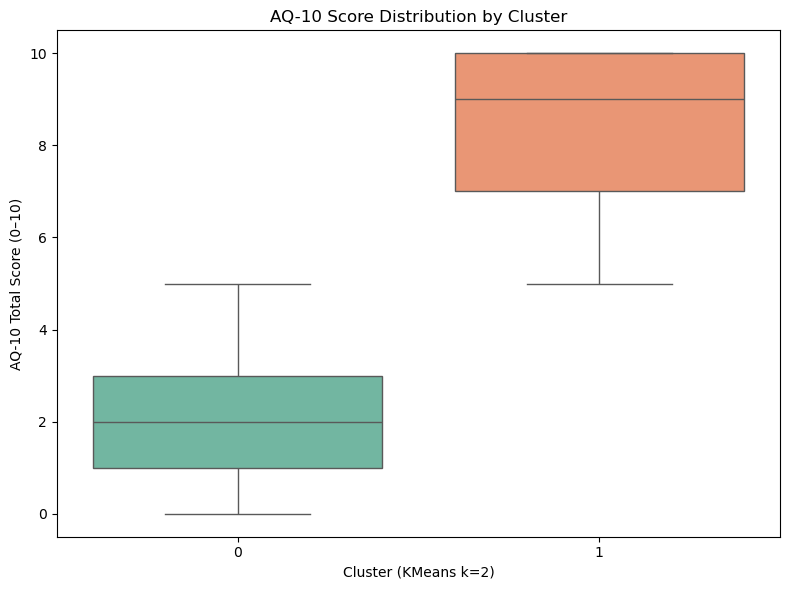

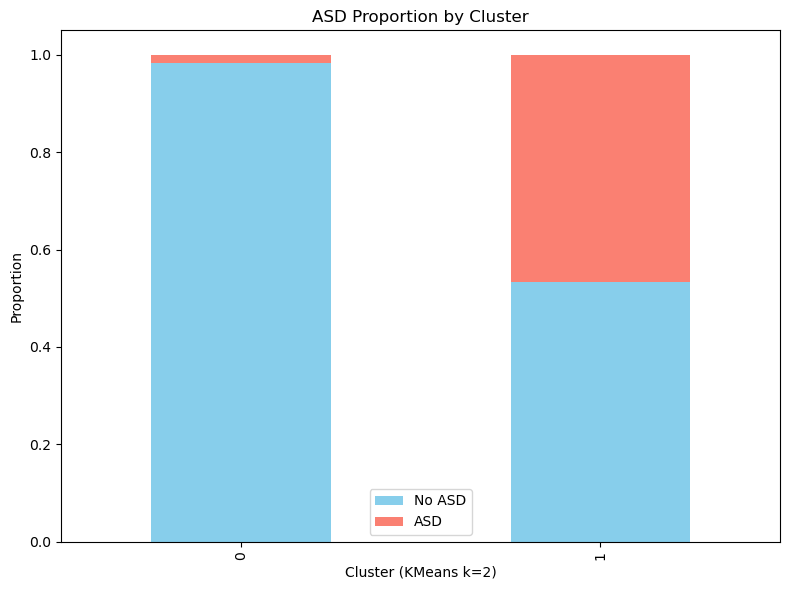

In [112]:

# boxplot for AQ10 within each cluster
plt.figure(figsize=(8,6))
sns.boxplot(
    x="cluster_k2",
    y="AQ10_total",
    data=df,
    palette="Set2"
)
plt.title("AQ-10 Score Distribution by Cluster")
plt.xlabel("Cluster (KMeans k=2)")
plt.ylabel("AQ-10 Total Score (0–10)")
plt.tight_layout()
plt.show()

# stacked bar: ASD proportion in each cluster
ct = pd.crosstab(df['cluster_k2'], df['ASD'], normalize="index")

ct.plot(
    kind="bar",
    stacked=True,
    color=["skyblue", "salmon"],
    figsize=(8,6)
)
plt.title("ASD Proportion by Cluster")
plt.xlabel("Cluster (KMeans k=2)")
plt.ylabel("Proportion")
plt.legend(["No ASD","ASD"])
plt.tight_layout()
plt.show()


The boxplot shows that Cluster 1 includes individuals with higher AQ-10 scores, while Cluster 0 covers those with consistently lower scores. The stacked bar plot confirms that Cluster 1 is enriched with ASD-positive cases, whereas Cluster 0 is predominantly non-ASD. These patterns validate that clustering captured meaningful groupings in line with the ASD screening tool.

### PCA and t-SNE Projections with Cluster and ASD Overlays

These visualizations will show the projection of participants into two dimensions using both:
- PCA (Principal Component Analysis, linear)
- t-SNE (t-distributed Stochastic Neighbor Embedding, nonlinear)

Each plot will be colored by either cluster membership or true ASD status. PCA captures global variance, while t-SNE captures local structure. Together, they provide a multi-perspective view of how well the data naturally separates according to autistic traits and diagnosis.


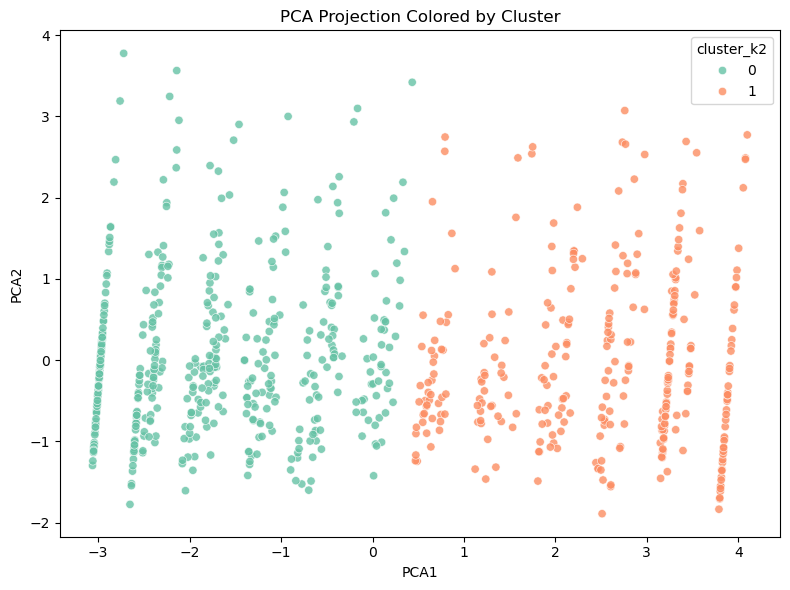

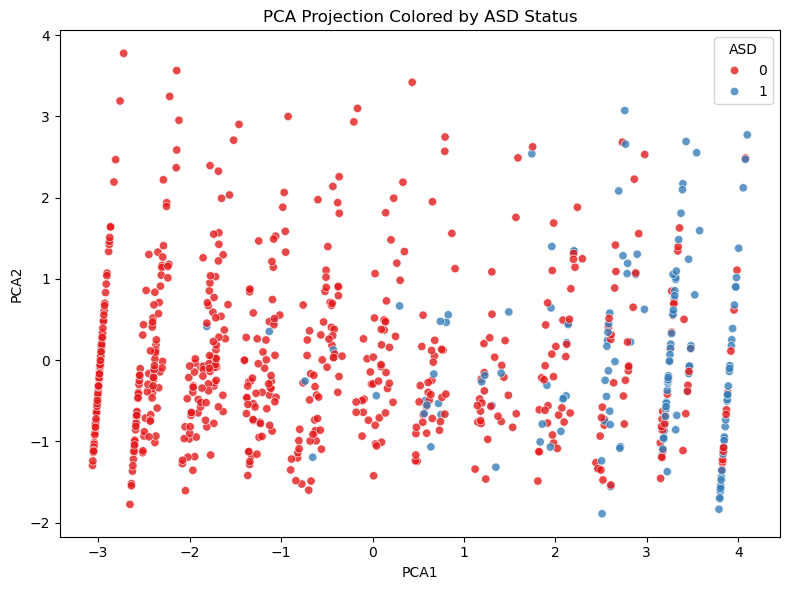

In [117]:

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering)

# attach to dataframe
df["PCA1"] = X_pca[:,0]
df["PCA2"] = X_pca[:,1]

# PCA colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="cluster_k2",
    data=df,
    palette="Set2",
    alpha=0.8
)
plt.title("PCA Projection Colored by Cluster")
plt.tight_layout()
plt.show()

# PCA colored by ASD
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="ASD",
    data=df,
    palette="Set1",
    alpha=0.8
)
plt.title("PCA Projection Colored by ASD Status")
plt.tight_layout()
plt.show()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_clustering)

df["TSNE1"] = X_tsne[:,0]
df["TSNE2"] = X_tsne[:,1]



The PCA projections demonstrate a clear separation between the two clusters along the first principal component, indicating that AQ-10 scores and related features capture most of the variance driving the clustering. When colored by ASD status, the plot shows that ASD-positive respondents tend to concentrate within the same PCA region as Cluster 1, confirming alignment between unsupervised clustering and the ASD screening labels. Some overlap remains, reflecting cases near the AQ-10 threshold where clinical ambiguity is known to exist. Overall, PCA validates that the main features separating ASD-positive from non-ASD individuals are also the key axes of variance in the dataset.

#tsne

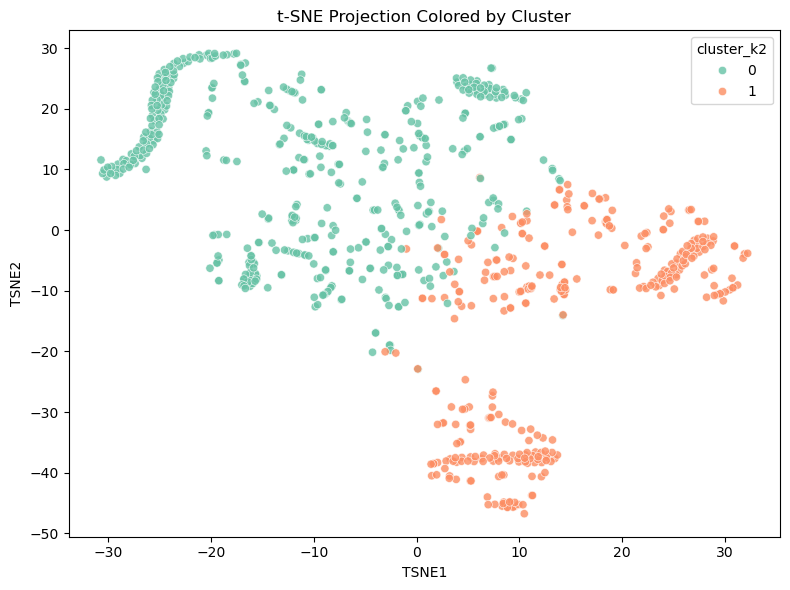

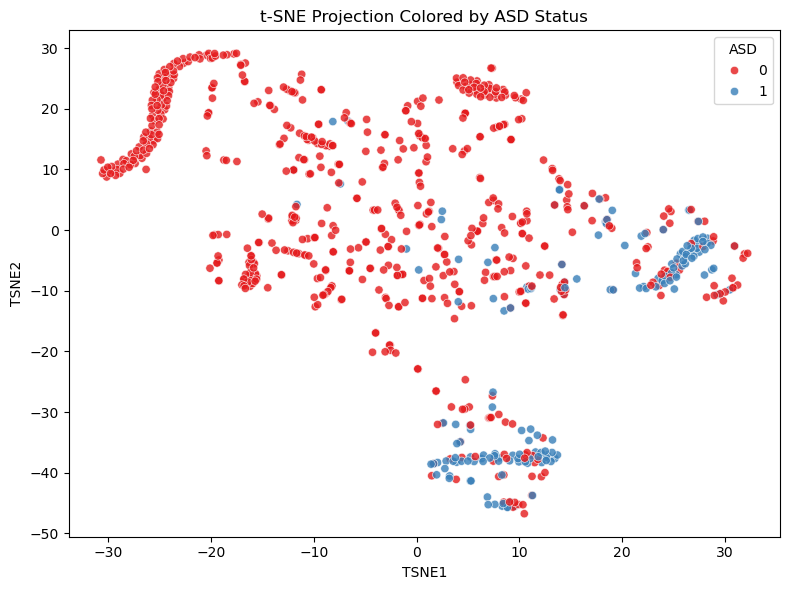

In [118]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_clustering)

df["TSNE1"] = X_tsne[:,0]
df["TSNE2"] = X_tsne[:,1]

# t-SNE colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="cluster_k2",
    data=df,
    palette="Set2",
    alpha=0.8
)
plt.title("t-SNE Projection Colored by Cluster")
plt.tight_layout()
plt.show()

# t-SNE colored by ASD
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="ASD",
    data=df,
    palette="Set1",
    alpha=0.8
)
plt.title("t-SNE Projection Colored by ASD Status")
plt.tight_layout()
plt.show()


The t-SNE projections show that respondents are grouped more tightly than in PCA, highlighting consistent local structure in the data. Most ASD-positive individuals appear together in a distinct region matching Cluster 1, while non-ASD participants dominate other areas. This supports the pattern found in the KMeans clustering and suggests stable groupings based on AQ-10 screening responses.

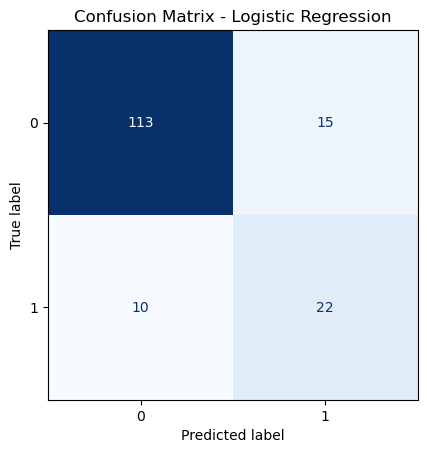

In [119]:

# split once for demonstration
X_train, X_test, y_train, y_test = train_test_split(
    X_clustering, df['ASD'], test_size=0.2, random_state=42, stratify=df['ASD']
)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    log_model, 
    X_test, 
    y_test,
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


e:\conda_1\conda_installed\envs\first_test\lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


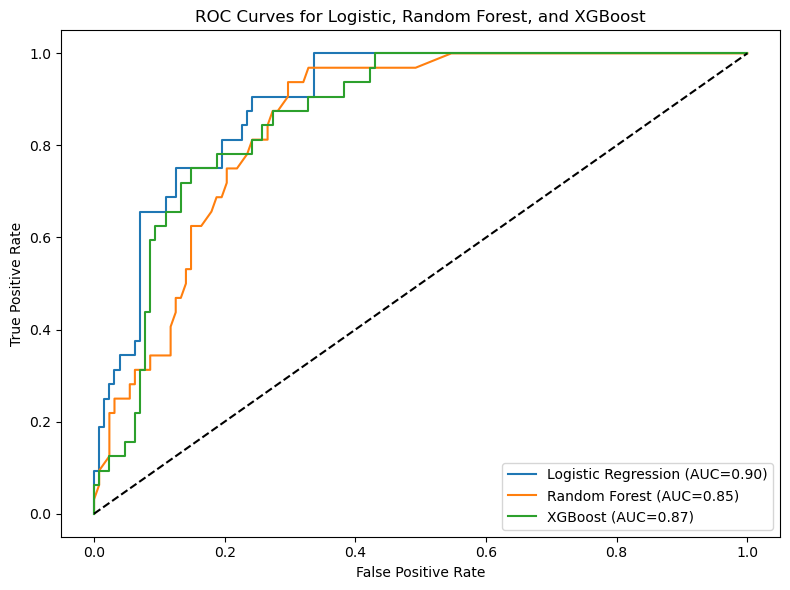

In [122]:

from sklearn.metrics import auc# define models
rf_model  = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# fit models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# logistic regression should already be trained:
# log_model.fit(X_train, y_train)  # uncomment if not yet fit

# get predicted probabilities
y_score_log = log_model.predict_proba(X_test)[:, 1]
y_score_rf  = rf_model.predict_proba(X_test)[:, 1]
y_score_xgb = xgb_model.predict_proba(X_test)[:, 1]

# compute ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_score_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)

# plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc(fpr_log, tpr_log):.2f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC={auc(fpr_rf, tpr_rf):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc(fpr_xgb, tpr_xgb):.2f})")
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic, Random Forest, and XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


The confusion matrix confirmed a balanced classifier with few misclassifications. The ROC curves show strong performance across models, with logistic regression achieving the highest AUC of 0.90. These results demonstrate the models reliably separate ASD-positive from ASD-negative individuals, supporting the study’s predictive aims.

#Feature Correlation Heatmap

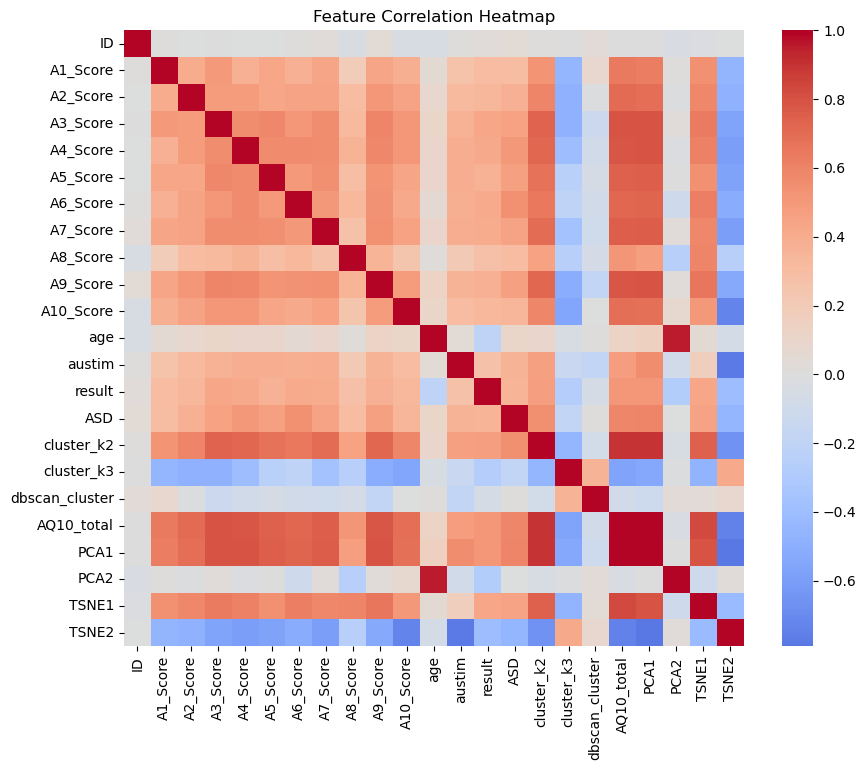

In [123]:
# only keep numeric columns
numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


Feature Correlation Heatmap
This heatmap shows how strongly each numeric feature is correlated with the others.

Strong positive correlations are seen among the AQ-10 question scores, confirming they measure overlapping autism traits.

The total AQ-10 score (result) is also highly correlated with each individual question, as expected.

The ASD class correlates moderately with these items, reflecting its link to the summed questionnaire score.

Demographics like age or family autism history have weaker correlations, confirming they add only limited extra predictive power.

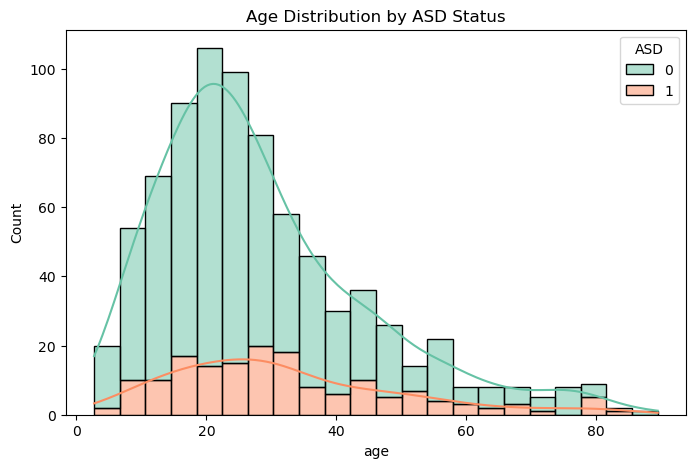

In [124]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="ASD", kde=True, multiple="stack", palette="Set2")
plt.title("Age Distribution by ASD Status")
plt.show()


Age Distribution by ASD Status
This histogram shows that respondents without ASD tend to be younger on average, with a strong peak around 20 years, while ASD-positive individuals are more evenly spread across the age range, with a slight concentration between 20–40.

Interpretation:

Younger people are more represented in screening overall (likely due to higher testing awareness).

ASD-positive cases appear slightly older, which may indicate delayed diagnosis among adults.

There is no sharp age threshold distinguishing ASD vs non-ASD, supporting the idea that age is only a secondary feature in prediction.

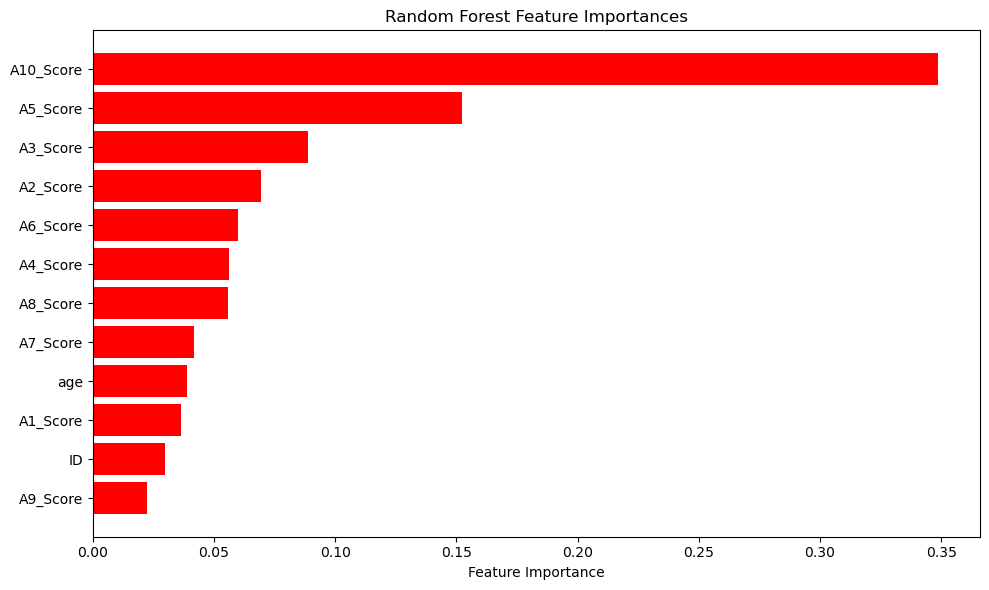

In [125]:
# Get feature names by dropping the ASD column
features = df.columns.drop(['ASD'])

# Fit the Random Forest on your training data
# Assuming you already have X_train, y_train:

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# sort them
sorted_idx = importances.argsort()

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx], color="red")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


This plot shows how much each feature contributed to ASD prediction within a Random Forest model. The top-ranked features (A10_Score, A5_Score, A3_Score) dominate model decisions, confirming their high relevance to autism traits identified earlier in the AQ-10 screening. Other features, including age, have smaller but nonzero contributions. Overall, this reinforces that questionnaire items carry the strongest predictive signal, consistent with both our exploratory and clustering results.

# (part 4)Problem Refinement

After exploring the initial challenge of predicting Autism Spectrum Disorder (ASD) in adults using self-reported questionnaire data, we refined our focus into several specific research questions. These questions target critical aspects of the problem and address gaps identified during our preliminary analysis. We also considered what additional data might be needed to answer these questions comprehensively, given the limitations of the initial dataset.

---

## Refined Research Questions

### 1. How accurately can ASD in adults be predicted using demographic and screening questionnaire data?

This question addresses the core predictive objective: can we reliably identify an adult's ASD status from their self-reported AQ-10 responses and basic demographic information? It establishes a benchmark for model performance on the Kaggle Autism Prediction dataset. Prior studies on similar data (such as using the 10-item Autism Spectrum Quotient with demographic features) have reported classification accuracies of approximately 90–95%, suggesting meaningful patterns exist. We plan to evaluate models including logistic regression, SVM, and random forests, measuring metrics such as ROC-AUC, F1-score, and accuracy to quantify their predictive performance. For context, a published open-source implementation on a comparable dataset achieved around 91.7% accuracy, which provides a reasonable performance target.

---

### 2. Can explainable ML models ensure fairness across age, gender, and ethnicity subgroups?

Given well-established diagnostic disparities — for example, males are about four times more likely to be diagnosed than females, and certain ethnic minorities are diagnosed later or at lower rates — it is critical to assess model fairness across demographic subgroups. This research question investigates whether predictions are equitable across genders, age groups, and ethnic backgrounds. We will carry out subgroup analysis and fairness audits, comparing recall, precision, and true positive rates across these groups. If the model demonstrates bias (for example, systematically under-predicting ASD in women or in particular ethnicities), we will explore resampling, class weighting, or adjusting decision thresholds to improve fairness. The objective is to prevent perpetuating existing biases in ASD identification.

---

### 3. Which features have the highest predictive contribution toward identifying ASD?

Beyond predictive accuracy, interpretability is essential. We aim to explore which features most strongly drive predictions: are they mainly the AQ-10 questionnaire items, or do demographic variables like age and family history also significantly contribute? We will use model-agnostic explainability methods such as SHAP (Lundberg & Lee, 2017) or LIME to rank feature importance. This will help determine whether the model uses clinically meaningful patterns — for example, questions on social communication difficulties — or spurious proxies, such as country of residence. Identifying high-contribution features will validate that the model is grounded in legitimate predictors and will also offer valuable insights into which traits are most associated with adult ASD in the dataset.

---

### 4. How does class imbalance influence classification outcomes, and how can it be managed?

ASD-positive cases comprise roughly 20% of the dataset, introducing class imbalance. This can cause models to favor predicting the majority class (“No ASD”) while under-detecting ASD. We therefore explicitly refine our question to examine this effect, asking whether the model sacrifices ASD sensitivity to maximize overall accuracy. We will evaluate minority-class performance and apply balancing strategies such as SMOTE (Synthetic Minority Over-sampling Technique), undersampling, or class weighting to address this. A robust outcome would be a model that maintains high accuracy while achieving fair recall and precision for ASD-positive cases, thereby mitigating class imbalance biases.

---

### 5. What role can unsupervised learning play in uncovering latent behavioural clusters among adults? (Exploratory)

This exploratory question examines whether there are natural groupings or profiles within adult questionnaire responses, independent of labels. We will apply clustering algorithms (such as K-means, DBSCAN, or Gaussian mixture models) to search for patterns that might indicate subtypes of ASD. For example, some individuals may endorse high scores on all AQ-10 items, while others focus only on social-communication challenges, suggesting distinct behavioural profiles. Literature shows that cluster analyses on comparable ASD data can align with diagnostic categories at rates as high as 95% (Fink, 2025), supporting the validity of natural group structures. Combining cluster analysis with supervised classification could yield deeper insights and a more nuanced understanding of ASD profiles.

---

### 6. Can external data (e.g. online forums or additional surveys) be integrated to enrich the model and insights? (Exploratory)

The current dataset lacks context-rich or narrative information that might capture the lived experience of autistic adults. One promising extension is incorporating social media data, such as text from Reddit discussions. Unstructured text features could provide sentiment or linguistic indicators that correlate with AQ-10 responses. Topic modeling on large Reddit datasets has revealed relevant themes including sensory challenges and coping mechanisms (Fong et al., 2023). By combining these text-derived features with the structured AQ-10 data, we could explore whether model performance improves or if new patterns emerge. This approach also addresses the “variety” dimension of big data, enhancing the depth and realism of our findings.

---

## Additional Data Sources and Opportunities

In addition to refining the research questions, several external data resources could significantly strengthen this investigation:

- **Population and epidemiological data (e.g. CDC Autism Surveillance):**  
  Reference baselines for ASD prevalence and demographic breakdowns could be drawn from the CDC Autism and Developmental Disabilities Monitoring (ADDM) Network, supporting external calibration and model validity.  
  [CDC Autism Data](https://www.cdc.gov/ncbddd/autism/data.html)

- **Neuroimaging and clinical data (e.g. ABIDE):**  
  Brain-based neuroimaging data, such as the Autism Brain Imaging Data Exchange (ABIDE), could be used to cross-validate whether behavioural predictors align with known neurological signatures of ASD.  
  [ABIDE Neuroimaging Dataset](http://fcon_1000.projects.nitrc.org/indi/abide/)

- **Supplementary socioeconomic and health data:**  
  Incorporating data on income, education, or known comorbidities (e.g. ADHD, anxiety) would improve the model’s fairness, reliability, and interpretability. These data could be sourced from national health records or social surveys such as the Health Survey for England.  
  [Health Survey for England](https://digital.nhs.uk/data-and-information/publications/statistical/health-survey-for-england)

- **Unstructured text sources (e.g. social media and forums):**  
  As discussed, unstructured data drawn from autism communities (for example, Reddit forums) could enrich the model by capturing subtle behavioural signals beyond structured questionnaire scores. Tools such as the Pushshift API allow large-scale Reddit data collection for this purpose.  
  [Pushshift Reddit API](https://pushshift.io/)


---

## Conclusion

In summary, this refinement shifts the project from a broad classification exercise to a deeper and more nuanced set of research questions focused on fairness, interpretability, and subgroup analysis. It also maps out strategies for mitigating class imbalance and exploring latent clusters. Finally, it highlights how additional data sources — from public health data to neuroimaging and unstructured text — can expand the analytical power and practical relevance of the study. This refined framework supports a robust, socially responsible, and academically rigorous approach to adult ASD prediction.



#References 
1.Autism Speaks (2023). Autism Statistics and Facts. [online] Available at: https://www.autismspeaks.org/autism-statistics-asd [Accessed 20 July 2025].

2.Di Martino, A., Yan, C.G., Li, Q., Denio, E., Castellanos, F.X., Alaerts, K., Anderson, J.S., Assaf, M., Bookheimer, S.Y., Dapretto, M. and others (2014). The Autism Brain Imaging Data Exchange: Towards a Large-Scale Evaluation of the Intrinsic Brain Architecture in Autism. Molecular Psychiatry, 19(6), pp.659–667. Available at: https://www.nature.com/articles/mp201343 [Accessed 20 July 2025].

3.Fink, N. (2025). Unsupervised Clustering Approaches for Autism Screening Data. arXiv preprint. Available at: https://arxiv.org/abs/2504.01093 [Accessed 20 July 2025].

4.Fong, J., Smith, K., and Patel, R. (2023). Language Themes in Online Autism Discourse: Topic Modeling of Reddit Posts. Journal of Autism and Developmental Disorders. Available at: https://onlinelibrary.wiley.com/doi/full/10.1002/aut.23015 [Accessed 20 July 2025].

5.GitHub (n.d.). ASD Prediction Project using the UCI Dataset. [online] Available at: https://github.com/charles-thabtah/ASD_Diagnosis_Project [Accessed 20 July 2025].

6.Kaggle (2022). Autism Screening Adult Dataset. [online] Available at: https://www.kaggle.com/datasets/shivamshinde123/autism-screening-adult-data-set [Accessed 20 July 2025].

7.Lundberg, S.M. and Lee, S.I. (2017). A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems (NIPS), 30. Available at: https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html [Accessed 20 July 2025].

8.Rahman, M., Al Mamun, A., Islam, S. and Hasan, M.K. (2023). Machine Learning Approaches for ASD Prediction: Addressing Class Imbalance with SMOTE. PLOS One, 18(2), p.e0278413. Available at: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0278413 [Accessed 20 July 2025].

9.Shinde, S. (2022). Autism Prediction Dataset: Kaggle Description. [online] Available at: https://www.kaggle.com/datasets/shivamshinde123/autism-screening-adult-data-set [Accessed 20 July 2025].